In [13]:
import os
from pathlib import Path
import rasterio
import numpy as np

for split in ['train', 'val', 'test']:
    # Define paths
    train_labels_dir = Path(f"Data/{split}_labels")
    train_images_dir = Path(f"Data/{split}_images")
    # Initialize min/max/mean values
    label_min, label_max = float('inf'), float('-inf')
    image_min, image_max = float('inf'), float('-inf')
    label_sum, label_count = 0, 0
    image_sum, image_count = 0, 0

    # Process labels
    for label_file in train_labels_dir.glob('*.tiff'):
        with rasterio.open(label_file) as src:
            label = src.read()
            label_min = min(label_min, np.min(label))
            label_max = max(label_max, np.max(label))
            label_sum += np.sum(label)
            label_count += label.size

    # Process images 
    for image_file in train_images_dir.glob('*.tiff'):
        with rasterio.open(image_file) as src:
            data = src.read()
            image_min = min(image_min, np.min(data))
            image_max = max(image_max, np.max(data))
            image_sum += np.sum(data)
            image_count += data.size

    label_mean = label_sum / label_count
    image_mean = image_sum / image_count

    print(f"Label value range: [{label_min}, {label_max}], mean: {label_mean:.4f}")
    print(f"Image value range: [{image_min}, {image_max}], mean: {image_mean:.4f}")


/home/glyin/anaconda3/envs/granite_env/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Label value range: [-1.0, 5.9740142822265625], mean: -0.9317
Image value range: [-9999.0, 16348.0], mean: 17.1767
Label value range: [-1.0, 5.9740142822265625], mean: -0.9333
Image value range: [-9999.0, 8803.0], mean: 17.0648
Label value range: [-1.0, 5.9740142822265625], mean: -0.9328
Image value range: [-9999.0, 9562.0], mean: 17.8119


In [14]:
label[label>-1].shape



(834,)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read the CSV file
results_path = 'check_points/Portugal-lr_0.001-xnormby1.0-ynormby1.0/run_2024-12-12->07:50:12/test_results.csv'
df = pd.read_csv(results_path)
df['Actual'] = df['Actual']
df['Predicted'] = np.abs(df['Predicted'])
# Calculate absolute error (loss)
df['Error'] = np.abs(df['Actual'] - df['Predicted'])

# Create a figure with subplots
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2)

# 1. Scatter plot of Predicted vs Actual
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(df['Actual'], df['Predicted'], alpha=0.5)
ax1.plot([df['Actual'].min(), df['Actual'].max()], 
         [df['Actual'].min(), df['Actual'].max()], 
         'r--', label='Perfect Prediction')
ax1.set_xlabel('Actual Biomass')
ax1.set_ylabel('Predicted Biomass')
# ax1.set_ylim(0, 10)
ax1.set_title('Predicted vs Actual Biomass')
ax1.legend()

# 2. Histogram of Actual Biomass
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(data=df, x='Actual', bins=30, ax=ax2)
ax2.set_xlabel('Actual Biomass')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Actual Biomass')

# 3. Error vs Actual Biomass
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(df['Actual'], df['Error'], alpha=0.5)
ax3.set_xlabel('Actual Biomass')
ax3.set_ylabel('Absolute Error')
ax3.set_title('Error vs Actual Biomass')

# 4. Histogram of Errors
ax4 = fig.add_subplot(gs[1, 1])
sns.histplot(data=df, x='Error', bins=30, ax=ax4)
ax4.set_xlabel('Absolute Error')
ax4.set_ylabel('Count')
ax4.set_title('Distribution of Prediction Errors')

# Add overall title and adjust layout
plt.suptitle('Biomass Prediction Analysis', fontsize=16)
plt.tight_layout()

# Save the plot
plot_path = results_path.replace('test_results.csv', 'analysis_plot.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.close()

# Print some basic statistics
print("\nStatistics:")
print(f"Mean Absolute Error: {df['Error'].mean():.4f}")
print(f"Standard Deviation of Error: {df['Error'].std():.4f}")
print(f"Mean Actual Biomass: {df['Actual'].mean():.4f}")
print(f"Mean Predicted Biomass: {df['Predicted'].mean():.4f}")
# Calculate R-squared
ss_res = ((df['Actual'] - df['Predicted']) ** 2).sum()
ss_tot = ((df['Actual'] - df['Actual'].mean()) ** 2).sum()
r2 = 1 - (ss_res / ss_tot)
print(f"R-squared: {r2:.4f}")



Statistics:
Mean Absolute Error: 17.4910
Standard Deviation of Error: 27.8081
Mean Actual Biomass: 27.1879
Mean Predicted Biomass: 28.2359
R-squared: 0.4441


In [ ]:
import os
import numpy as np
import rasterio
from collections import Counter

# Directory containing training labels
# train_labels_dir = "Dataset/V2/labels"
train_labels_dir = "Running_Dataset/V2/raw/train_labels"

# List to store biomass values
biomass_values = []

# Read all label files and collect biomass values
print("Collecting biomass values from training labels...")
for filename in os.listdir(train_labels_dir):
    if filename.endswith(".tiff"):
        filepath = os.path.join(train_labels_dir, filename)
        with rasterio.open(filepath) as src:
            data = src.read(1)  # Read first band
            # Collect non-zero and non-negative biomass values 
            valid_biomass = data[data > 0]
            biomass_values.extend(valid_biomass.flatten())

# Count occurrences of each biomass value
biomass_counts = Counter(biomass_values)

# Print counts sorted by biomass value
# print("\nBiomass value distribution in training labels:")
# print("Biomass Value | Count")
# print("-" * 25)
# for value in sorted(biomass_counts.keys()):
#     print(f"{value:12.1f} | {biomass_counts[value]:6d}")

# Print total number of valid biomass pixels
total_pixels = sum(biomass_counts.values())
print(f"\nTotal number of valid biomass pixels: {total_pixels}")

# Print minimum value count
min_count = min(biomass_counts.values())
min_biomass = min(biomass_counts.keys())
print(f"\nMinimum count: {min_count} (for biomass value {min_biomass})")

# Create bins with resolution of 1
min_biomass_value = int(min(biomass_counts.keys()))
max_biomass_value = int(max(biomass_counts.keys()))
bins = range(min_biomass_value, max_biomass_value + 2)  # +2 to include the last value

# Count values in each bin
binned_counts = np.zeros(len(bins)-1)
for value, count in biomass_counts.items():
    bin_index = int(value) - min_biomass_value
    binned_counts[bin_index] += count

# Print binned distribution
print("\nBiomass value distribution by integer ranges:")
print("Range | Count")
print("-" * 25)
for i in range(len(bins)-1):
    range_start = bins[i]
    range_end = bins[i+1]
    count = int(binned_counts[i])
    if count > 0:  # Only print ranges that have values
        print(f"{range_start}-{range_end} | {count:6d}")




In [ ]:
import rasterio
from pathlib import Path
import matplotlib.pyplot as plt

# Load and check a specific label file
label_path = Path('Running_Dataset/V2/balanced/test_images/biomass_1-2_img1.tiff')
with rasterio.open(label_path) as src:
    label_data = src.read(1)  # Read first band
    
print(f"Label data shape: {label_data.shape}")

# Load and check a specific data file
data_path = Path('Running_Dataset/V2/balanced/test_labels/biomass_1-2_img16_label.tiff')
with rasterio.open(data_path) as src:
    data = src.read()  # Read all bands
    
print(f"Input data shape: {data.shape}")




Checking file: GEDI04_A_2020086225006_O07295_03_T00950_02_002_02_V002_patch_10.tiff
Data shape: (9, 224, 223)
Label shape: (224, 223)
Number of valid label pixels: 911


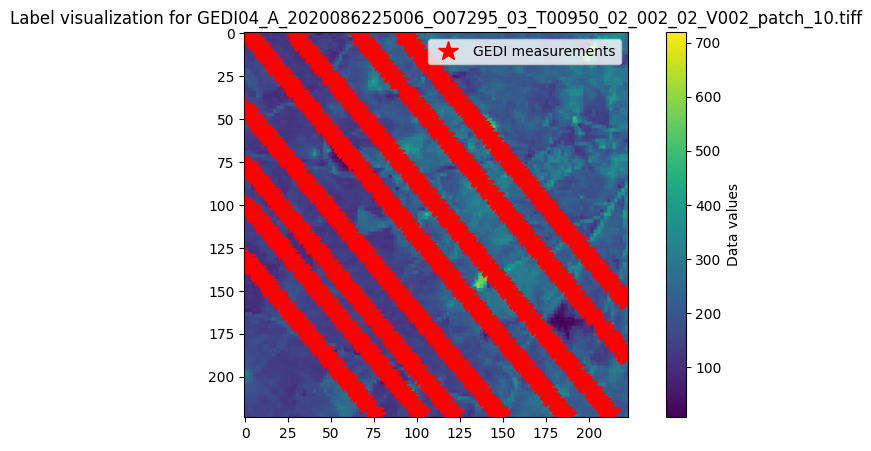


Checking file: GEDI04_A_2021208215339_O14859_03_T10452_02_002_02_V002_patch_34.tiff
Data shape: (9, 224, 223)
Label shape: (224, 223)
Number of valid label pixels: 569


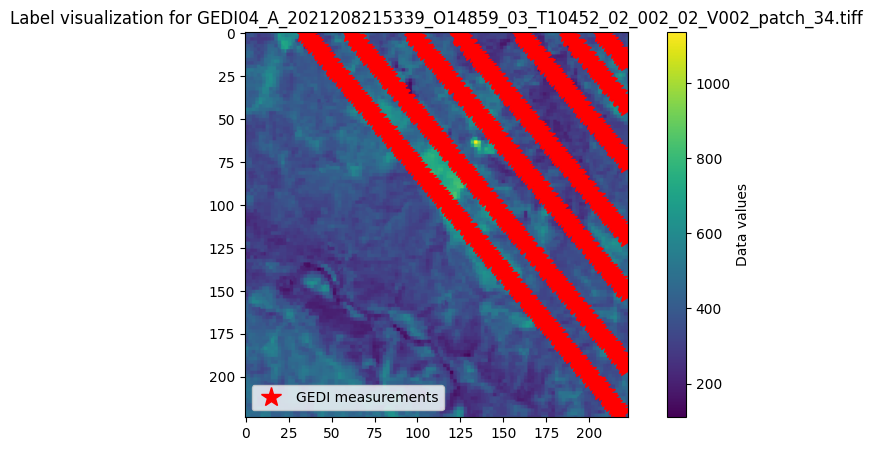


Checking file: GEDI04_A_2021348082747_O17020_02_T10601_02_002_02_V002_patch_40.tiff
Data shape: (9, 224, 223)
Label shape: (224, 223)
Number of valid label pixels: 111


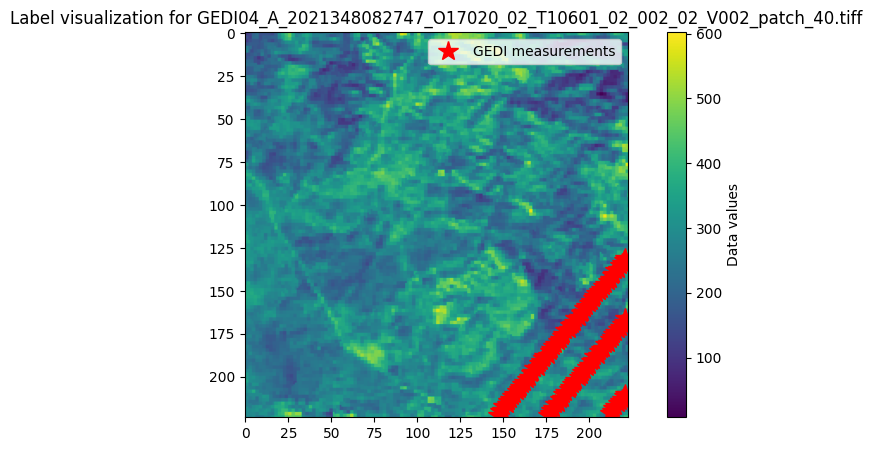


Checking file: GEDI04_A_2020015204510_O06193_02_T00334_02_002_02_V002_patch_47.tiff
Data shape: (9, 225, 221)
Label shape: (225, 221)
Number of valid label pixels: 191


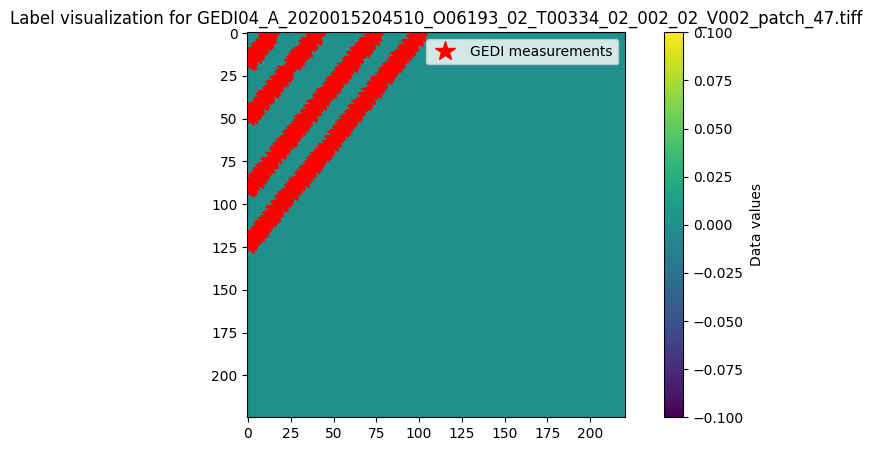

In [13]:
import rasterio
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

data_path = Path('Dataset/V2/data')
label_path = Path('Dataset/V2/labels')

# Get list of all data files
data_files = list(data_path.glob('*.tiff'))

# Load and check a few random data-label pairs
for data_file in data_files[:4]:  # Check first 5 files
    print("\nChecking file:", data_file.name)
    
    # Load data
    with rasterio.open(data_file) as src:
        data = src.read()
        
    # Construct corresponding label filename
    label_file = label_path / (data_file.stem + '_label.tiff')
    
    if label_file.exists():
        with rasterio.open(label_file) as src:
            label = src.read(1)
            
        # Count valid label pixels (not -1)
        valid_pixels = (label != -1).sum()
        
        print(f"Data shape: {data.shape}")
        print(f"Label shape: {label.shape}")
        print(f"Number of valid label pixels: {valid_pixels}")
        # print(f"Unique label values: {np.unique(label)}")
        
        plt.figure(figsize=(10, 5))
        plt.subplot(111)
        img_data = plt.imshow(data[0], cmap='viridis')  # Store the result of imshow
        plt.title('Data')
        valid_points = np.where(label != -1)
        if len(valid_points[0]) > 0:
            # Plot GEDI points on the data plot
            plt.plot(valid_points[1], valid_points[0], 'r*', markersize=15, label='GEDI measurements')


        plt.colorbar(img_data, label='Data values')  # Pass the mappable to colorbar
        plt.title(f'Label visualization for {data_file.name}')
        plt.legend()
        plt.show()
        plt.close()
    else:
        print("No corresponding label file found")



Training dataset size: 4698
Validation dataset size: 261
Test dataset size: 262


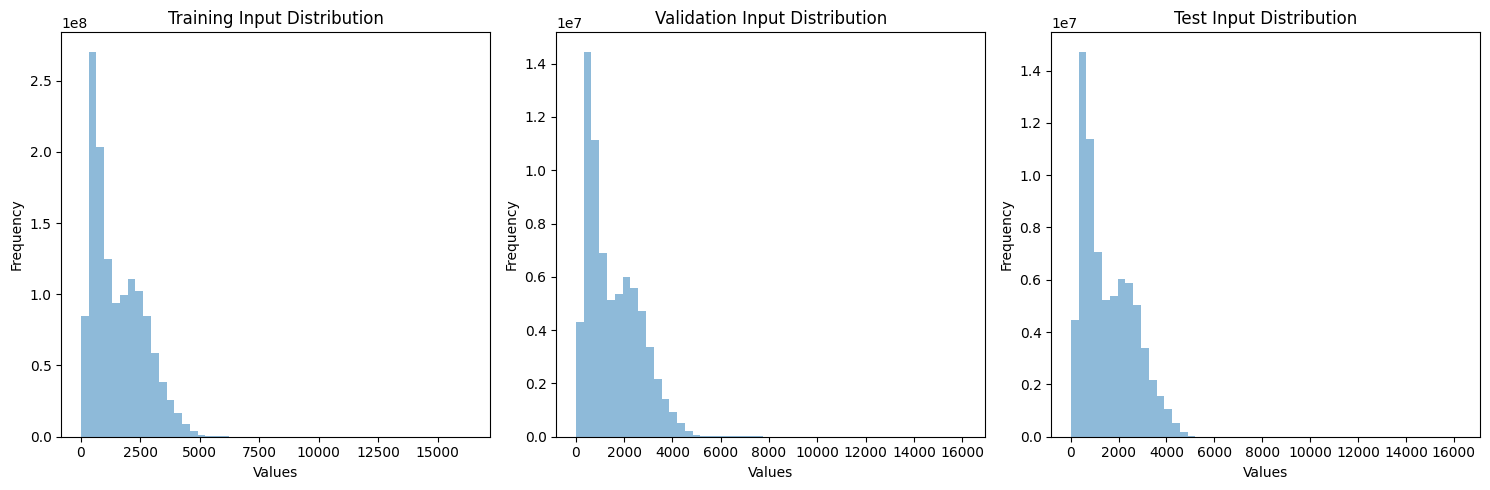

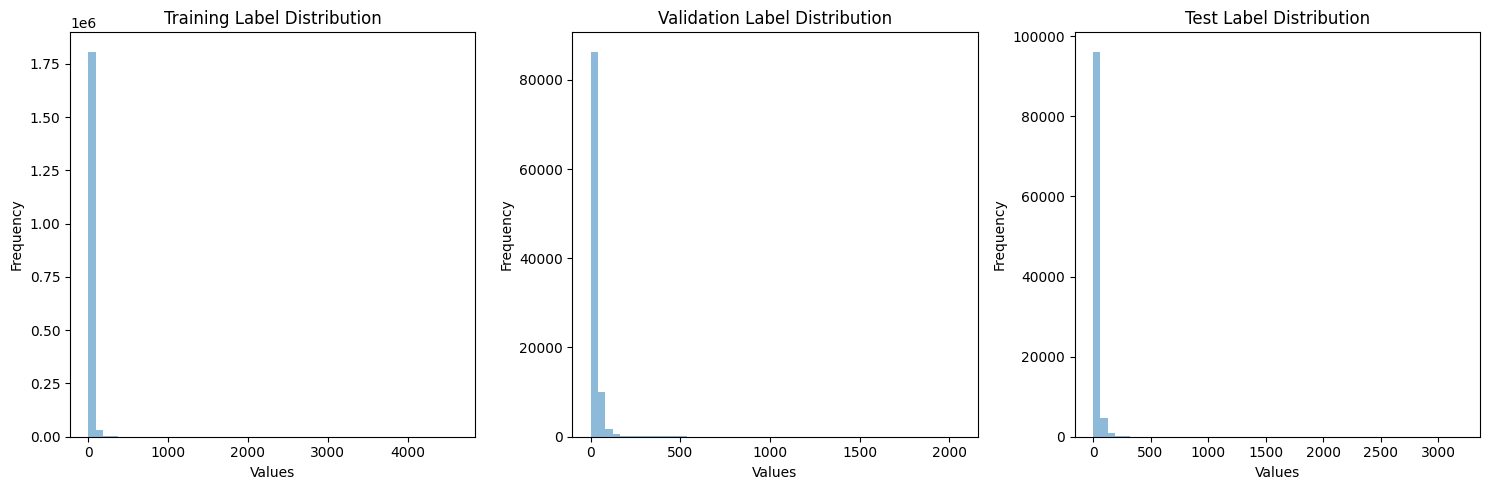


Total number of pixels:
Training - Input: 1328219820, Valid Labels: 1849572
Validation - Input: 72481596, Valid Labels: 99612
Test - Input: 74211150, Valid Labels: 102196

Value ranges:
Training - Input: [1.00, 16375.00], Label: [0.05, 4620.36]
Validation - Input: [1.00, 16132.00], Label: [0.08, 2054.84]
Test - Input: [1.00, 16282.00], Label: [0.09, 3204.36]


In [23]:
from matplotlib import pyplot as plt
from src.tools.dataset import TiffDataset
import numpy as np

# data_dir = './Running_Dataset/V2/raw'
# area = 'Portugal'

def analyze_datasets(data_dir):

    train_ds = TiffDataset(data_dir, split='train', selected_bands=[1,2,3,4,5,6])
    val_ds = TiffDataset(data_dir, split='val', selected_bands=[1,2,3,4,5,6])
    test_ds = TiffDataset(data_dir, split='test', selected_bands=[1,2,3,4,5,6])
    print("Training dataset size:", len(train_ds))
    print("Validation dataset size:", len(val_ds)) 
    print("Test dataset size:", len(test_ds))

    # Print sample information from first item in each dataset
    # Get samples from each dataset
    # Get all samples from each dataset
    train_data = []
    train_labels = []
    val_data = []
    val_labels = []
    test_data = []
    test_labels = []
    
    train_data_mask = []
    val_data_mask = []
    test_data_mask = []
    print("Collecting training data...")
    for i in range(len(train_ds)):
        x, y = train_ds[i]
        train_data.append(x)
        train_labels.append(y)
        mask = x[-1]
        train_data_mask.append(mask)
    
    print("Collecting validation data...")    
    for i in range(len(val_ds)):
        x, y = val_ds[i]
        val_data.append(x)
        val_labels.append(y)
        mask = x[-1]
        val_data_mask.append(mask)
        
    print("Collecting test data...")
    for i in range(len(test_ds)):
        x, y = test_ds[i]
        test_data.append(x)
        test_labels.append(y)
        mask = x[-1]
        test_data_mask.append(mask)
    # Concatenate all data
    train_data = np.concatenate([x.flatten() for x in train_data])
    train_labels = np.concatenate([y.flatten() for y in train_labels])
    val_data = np.concatenate([x.flatten() for x in val_data])
    val_labels = np.concatenate([y.flatten() for y in val_labels])
    test_data = np.concatenate([x.flatten() for x in test_data])
    test_labels = np.concatenate([y.flatten() for y in test_labels])

    # Plot distribution of input values for each dataset
    def plot_distributions(data_arrays, titles, suptitle):
        plt.figure(figsize=(15, 5))
        for i, (data, title) in enumerate(zip(data_arrays, titles), 1):
            plt.subplot(1, 3, i)
            plt.hist(data, bins=50, alpha=0.5)
            plt.title(f'{title} Distribution')
            plt.xlabel('Values')
            plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

    # Plot input distributions
    plot_distributions(
        [train_data, val_data, test_data],
        ['Training Input', 'Validation Input', 'Test Input'],
        'Input Distributions'
    )

    # Plot label distributions (excluding negative values)
    plot_distributions(
        [train_labels[train_labels>0], val_labels[val_labels>0], test_labels[test_labels>0]],
        ['Training Label', 'Validation Label', 'Test Label'],
        'Label Distributions'
    )

    # Print shape information
    print("\nTotal number of pixels:")
    print(f"Training - Input: {len(train_data)}, Valid Labels: {len(train_labels[train_labels>0])}")
    print(f"Validation - Input: {len(val_data)}, Valid Labels: {len(val_labels[val_labels>0])}") 
    print(f"Test - Input: {len(test_data)}, Valid Labels: {len(test_labels[test_labels>0])}")
    
    print("\nValue ranges:")
    print(f"Training - Input: [{train_data.min():.2f}, {train_data.max():.2f}], Label: [{train_labels[train_labels>0].min():.2f}, {train_labels[train_labels>0].max():.2f}]")
    print(f"Validation - Input: [{val_data.min():.2f}, {val_data.max():.2f}], Label: [{val_labels[val_labels>0].min():.2f}, {val_labels[val_labels>0].max():.2f}]")
    print(f"Test - Input: [{test_data.min():.2f}, {test_data.max():.2f}], Label: [{test_labels[test_labels>0].min():.2f}, {test_labels[test_labels>0].max():.2f}]")
    return train_data, train_labels, val_data, val_labels, test_data, test_labels, [train_data_mask, val_data_mask, test_data_mask]
# train_data_taiga, train_labels_taiga, val_data_taiga, val_labels_taiga, test_data_taiga, test_labels_taiga, masks_taiga = analyze_datasets('../granite-geospatial-biomass-datasets/taiga_datasplit')
train_data, train_labels, val_data, val_labels, test_data, test_labels, masks = analyze_datasets('./Running_Dataset/V2/raw_')


In [13]:
print(f"Training - Input: [{train_data.min():.2f}, {train_data.max():.2f}], Label: [{train_labels[train_labels>0].min():.2f}, {train_labels[train_labels>0].max():.2f}]")


Training - Input: [nan, nan], Label: [0.05, 4620.36]


In [4]:
from pathlib import Path
len(list(Path('Running_Dataset/V2/raw_224/train_images').glob('*.tiff')))

4259